# Testing pruning methods

In this notebook, we will test the pruning methods. We have assumed that we will decouple the structure discovery problem into finding the order and then using a post-processing module to figure out the actual underlying graph via pruning. Therefore, this notebook assumes we have a correct causal ordering and will try to move further on using that baseline.

In this notebook, we will work with one of the `bnlearn` datasets and perform a topological ordering on the actual graph to obtain a correct causal ordering. To do so, customize the dataset that you intend to work on in the following:

In [1]:
DATASET_NAME = 'asia' # You can set it to 'sachs', 'alarm', 'asia' or any other bnlearn datasets

Now use the following to generate a set of samples from the dataset of choice. This will use the code in the datamodule.

In [2]:
import sys
sys.path.append('..')

# setup data
from ocd.data import CausalDataModule
import dypy
import torch

dypy.register_context(torch)

dm = CausalDataModule(
    name=DATASET_NAME,  # small dataset asia
    observation_size=4096,  # number of observation samples
    intervention_size=0,  # set to 0 for no intervention
    batch_size=128,
    num_workers=0,  # set to 0 for no multiprocessing
    val_size=0,  # 10% of data for validation, or use int for exact number of samples, set to 0 for no validation
)
dm.setup("fit")



[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </home/hamidreza/Work/myprojects/ocd/venv/lib/python3.10/site-packages/bnlearn/data/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Check whether CPDs associated with the nodes are consistent: True


Run the following piece of code to plot the actual underlying structure as a DAG.

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </home/hamidreza/Work/myprojects/ocd/venv/lib/python3.10/site-packages/bnlearn/data/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Check whether CPDs associated with the nodes are consistent: True
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


{'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'asia': array([ 0.43475336, -0.1296038 ]),
  'tub': array([ 0.10931059, -0.27894295]),
  'smoke': array([-0.12740337,  0.27436123]),
  'lung': array([0.05785294, 0.01807246]),
  'bronc': array([-0.32439377,  0.46752833]),
  'either': array([-0.06456299, -0.12734101]),
  'xray': array([ 0.59205122, -1.        ]),
  'dysp': array([-0.67760798,  0.77592574])},
 'G': <networkx.classes.digraph.DiGraph at 0x7f36e341db40>,
 'node_properties': {'asia': {'node_color': '#1f456e', 'node_size': 800},
  'tub': {'node_color': '#1f456e', 'node_size': 800},
  'smoke': {'node_color': '#1f456e', 'node_size': 800},
  'lung': {'node_color': '#1f456e', 'node_size': 800},
  'bronc': {'node_color': '#1f456e', 'node_size': 800},
  'either': {'node_color': '#1f456e', 'node_size': 800},
  'xray': {'node_color': '#1f456e', 'node_size': 800},
  'dysp': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('asia', 'tub'): {'color': '#000000', 'weig

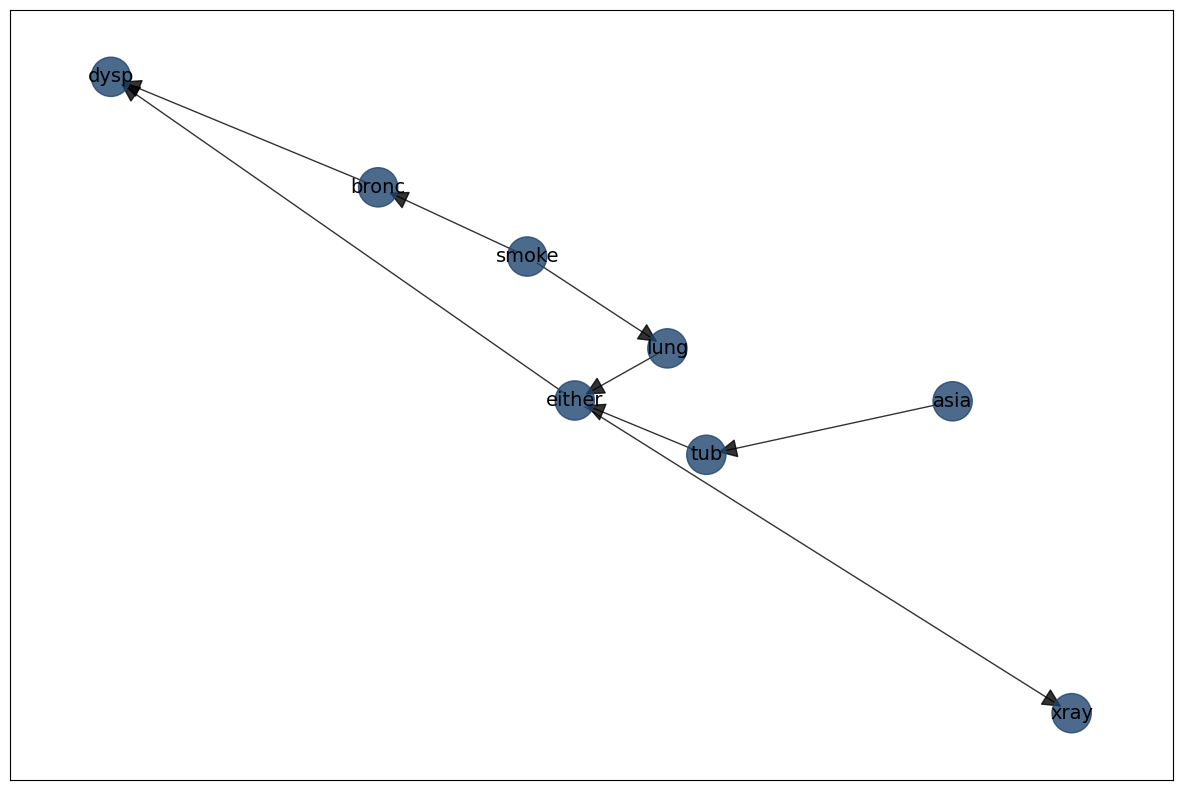

In [3]:
import bnlearn as bn

bn.plot(bn.import_DAG(DATASET_NAME))

Run the following piece of code to obtain a set of observational samples from the causal structure. You can also obtain the dataframe from the datamodule that has already been created. Simply choose which dataframe to go for.

In [4]:
import bnlearn as bn

# Set to true if you want to have the option to switch between the bnlearn dataset and the datamodule
prompt = False # True

resp = 'y' if not prompt else input('Use datamodule? (y/n) ')
if resp == 'y':
    df = dm.datasets[0].samples
else:
    df = bn.import_example(DATASET_NAME)
    df = df.reindex(sorted(df.columns), axis=1)

Run the following to obtain the correct causal ordering by a simple topological sort algorithm on the ground truth DAG. Note that there might be multiple correct causal orderings, therefore, you can specify a `seed` parameter that will randomize the process of getting the causal ordering. That way, you can obtain multiple orderings by tuning `seed`. That being said, a good pruning method should be oblivious to the causal ordering as long as it is a correct topological ordering of the ground truth DAG.

In [5]:
import random
from ocd.evaluation import topological_sort

# Set the seed of interest
random.seed(121)

# do a topological ordering on the DAG dm.datasets[0].dag
# then use that index to reorder the columns
topol_sorted = topological_sort(dm.datasets[0].dag)
print("The indices of the topoligical ordering")
print(topol_sorted)
col_names = []
for i in topol_sorted:
    col_names.append(dm.datasets[0].samples.columns[i])
print("The column names of the topological ordering (To check with the figure)")
print(col_names)

The indices of the topoligical ordering
[5, 4, 1, 0, 6, 3, 2, 7]
The column names of the topological ordering (To check with the figure)
['smoke', 'lung', 'bronc', 'asia', 'tub', 'either', 'dysp', 'xray']


Using the correct topological ordering, the following will perform a test on the prune function from `ocd.post_preocessing.pruning.prune`. You can also set an input DAG for the pruning method.

The method will obtain a `pruned_dag` and will compare it with the ground truth one in terms of structural hamming distance.

**Note**: An important test would be to give the ground truth DAG as an initializiation DAG. The method should not prune anything ideally and should simply return the whole DAG again.

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

from ocd.post_processing.pruning import prune
from ocd.post_processing.pruning import PruningMethod
from ocd.evaluation import shd

import numpy as np
ground_truth = dm.datasets[0].dag
pruned_dag = prune(topol_sorted, df, PruningMethod.CONDITIONAL_INDEPENDENCE_TESTING,
            # dag=ground_truth,
            verbose=1,
            method_params={
                'threshold': 0.01,
            }
            )

# Uncomment if you want to see the pruned DAG and the ground truth
# print(pruned_dag)
# print(ground_truth)

print("The number of edges in the original DAG is: ", np.sum(ground_truth).astype(int))
print("Structural hamming distance between pruned_dag and original_dag is: ", shd(pruned_dag, ground_truth))

100%|██████████| 8/8 [00:00<00:00, 12.79it/s]

The number of edges in the original DAG is:  8
Structural hamming distance between pruned_dag and original_dag is:  1


## Use interventional data

We have certain episodes of interventional data as well and we can facilitate them in our pruning procedure. For example, if we have a DAG and an interventional data on vertex `v` of the DAG, then we can do a similar process for the pruning. However, there is a caveat: we should ignore pruning the parents of `v`.

In the following, we will use interventional data from the data module that contains the intervention eposide **alongside the node that has been intervened on**. However, in testing the ensemble of models this is not the case and one should use a model to figure out which covariate has been intervened upon and then use that covariate for pruning.

In [8]:
ground_truth = dm.datasets[0].dag
pruned_dag = prune(topol_sorted, df, PruningMethod.CONDITIONAL_INDEPENDENCE_TESTING,
            # dag=ground_truth,
            verbose=1,
            method_params={
                'threshold': 0.02,
            }
            )
# get the interventional dataframes with the values of the intervention
for intervention_eposide in dm.datasets[1:]:
    intervention_node_name = intervention_eposide.intervention_node
    # check the index of the intervention node in intervention_eposide.samples.columns
    intervention_node_index = intervention_eposide.samples.columns.get_loc(intervention_node_name)

    pruned_dag = prune(topol_sorted, intervention_eposide.samples, PruningMethod.CONDITIONAL_INDEPENDENCE_TESTING,
                          dag=pruned_dag,
                       interventional_column=intervention_node_index,
                       verbose=1,
                       method_params={
                           'threshold': 0.01,
                           }
                        )


print("The number of edges in the original DAG is: ", np.sum(ground_truth).astype(int))
print("Structural hamming distance between pruned_dag and original_dag is: ", shd(pruned_dag, ground_truth))


100%|██████████| 8/8 [00:00<00:00, 12.88it/s]

The number of edges in the original DAG is:  8
Structural hamming distance between pruned_dag and original_dag is:  1
